<a href="https://colab.research.google.com/github/Bukhteev/portfolio/blob/main/Interpretation_homestask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Интерпретация моделей и калибровка вероятностей

Будем тренироваться на примере задачи классификации оттоковых клиентов

In [1]:
!pip install eli5 -q
!pip install lime -q
!pip install shap -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import eli5, lime, shap

from catboost import CatBoostClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Загрузим данные

In [32]:
data = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/churn_clients.csv")

data.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,KS,128,415,No,Yes,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,False


Обработайте признаки:

* удалите категориальные признаки с больше, чем двумя различными значениями (обратите внимание, что `areacode` - также категориальный признак)

* бинарные признаки перведите в числа: True/Yes -> 1, False/No -> 0

In [33]:
# your code here
cat_feature = ['areacode', 'internationalplan', 'state', 'voicemailplan', 'churn']
d = {'No':0, 'Yes':1, False:0, True:1}
for feature in cat_feature:
  if len(data[feature].unique()) > 2:
    data = data.drop(columns=feature)
  else:
    data[feature] = data[feature].map(d)
data.head()

,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,customerservicecalls,churn
0,128,0,1,25,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1,0
1,107,0,1,26,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1,0
2,137,0,0,0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0,0
3,84,1,0,0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2,0
4,75,1,0,0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3,0


## Вопрос

Сколько колонок осталось в таблице data?

(3333, 18)

In [18]:
# your code here
data.shape[1]

18

In [34]:
X = data.drop('churn', axis=1)
y = data['churn']

Разбейте данные на тренировочную и тестовую части. Размер тестовой части - 25%, `random_state=42`.

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# your code here

## Вопрос

Сколько строк в тренировочных данных?

In [36]:
# your code here
X_train.shape[0]

2499

Обучите CatBoostClassifier с гиперпараметрами по умолчанию и `random_state=42` на тренировочных данных, сделайте прогноз на тестовых данных и вычислите значение ROC-AUC.

In [46]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(random_state=42, verbose=False)

cat.fit(X_train, y_train)
pred_cat = cat.predict_proba(X_test)

# your code here

In [54]:
pred_cat

array([[0.93496755, 0.06503245],
       [0.98250557, 0.01749443],
       [0.04539252, 0.95460748],
       ...,
       [0.99131802, 0.00868198],
       [0.98578949, 0.01421051],
       [0.99219371, 0.00780629]])

## Вопрос

Чему равно значение ROC-AUC на тестовых данных? Ответ округлите до сотых.

In [57]:
from sklearn.metrics import roc_auc_score

# your code here
roc_auc_score(y_test, pred_cat[:,1])

0.9355035260930887

Выведите на экран гистограмму важности признаков (стандартную, посчитанную на основе Information Gain)

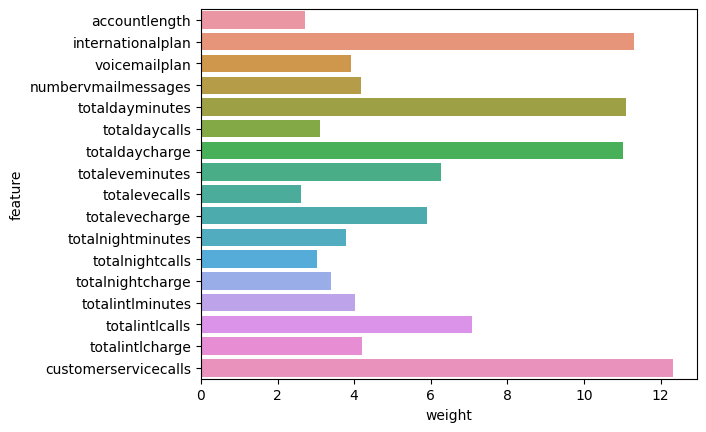

In [39]:
# your code here
model_imps = pd.DataFrame({"feature": X.columns,
                        "weight": cat.feature_importances_})
sns.barplot(data=model_imps, y="feature", x="weight")
plt.show()

## Вопрос

Какой признак наиболее важен с точки зрения этого подхода?

Постройте гистограмму permutation importance по тренировочным данным

In [41]:
# your code here
perm = eli5.sklearn.PermutationImportance(cat, random_state=42).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0599 ± 0.0047,customerservicecalls
0.0545 ± 0.0053,totaldaycharge
0.0519 ± 0.0045,internationalplan
0.0502 ± 0.0065,totaldayminutes
0.0241 ± 0.0031,totalintlcalls
0.0211 ± 0.0012,totaleveminutes
0.0189 ± 0.0014,totalevecharge
0.0142 ± 0.0026,numbervmailmessages
0.0138 ± 0.0032,voicemailplan
0.0130 ± 0.0015,totalintlcharge


## Вопрос

Сколько признаков выделяет метод как наиболее важные? (темно-зеленый цвет на визуализации)

Постройте гистограмму shap values по тестовым данным

In [58]:
# your code here
4

4

## Вопрос

Какой признак наименее важен с точки зрения подхода SHAP?

Проинтерпретируем теперь индивидуальные прогнозы моделей

Проинтерпретируйте прогноз на тестовом объекте с индексом 5 методами:

* SHAP
* LIME

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


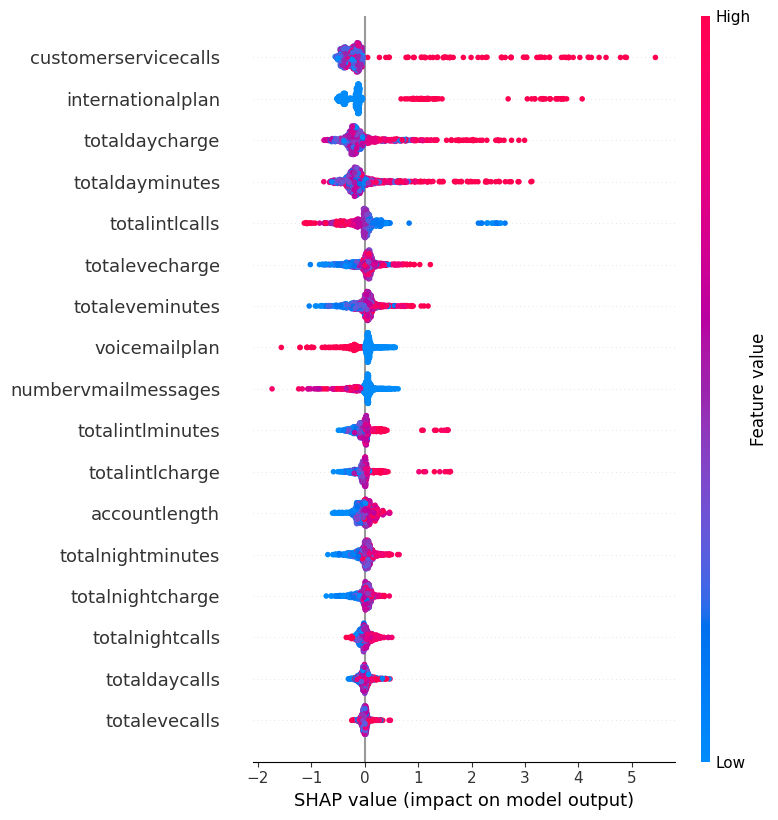

In [59]:
# your code here
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения SHAP?

In [60]:
# your code here
shap.initjs()

print('Correct answer:', y_test.iloc[2])
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:])

Correct answer: 1


## Вопрос

Какой признак дает наибольший вклад в прогноз с точки зрения метода LIME?

## Калибровка вероятностей

Сделайте калибровку вероятностей с помощью методов 'sigmoid' и 'isotonic' при помощи CalibratedClassifierCV с `cv=2`.

Нарисуйте на одном графике исходную калибровочную кривую для CatBoost и две кривые после калибровки.

In [65]:
# your code here

explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=X_test.columns.values.tolist(),  mode='classification')
explanation = explainer.explain_instance(X_test.values[2], cat.predict_proba, num_features=5)

explanation.show_in_notebook(show_table=True)

Вычислим `brier_score` до калибровки

In [67]:
from sklearn.metrics import brier_score_loss

brier_score_loss(y_test, pred_cat[:,1])

0.0335565178559375

## Вопрос

Вычислите `brier_score` после обеих калибровок.

В ответ запишите наименьшее из двух полученных значений, округленное до десятитысячных.

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


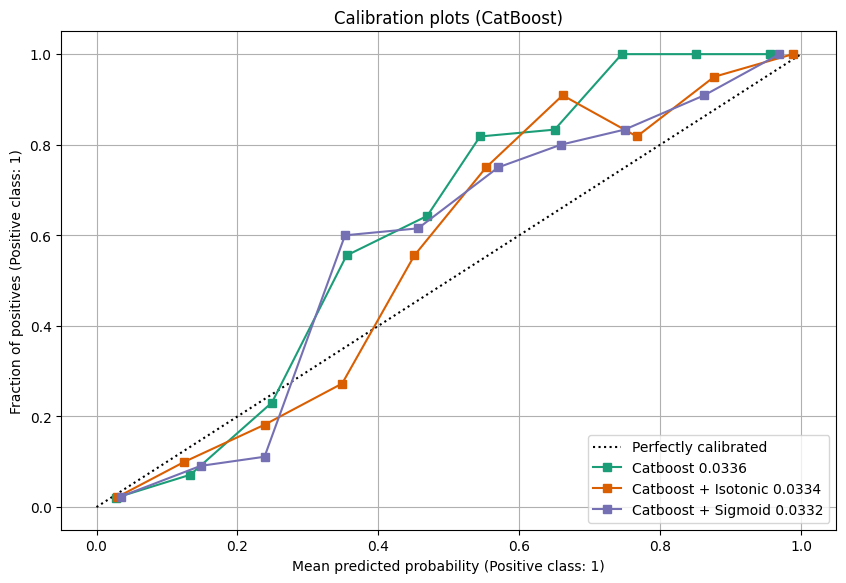

In [70]:
# your code here

from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
cat = CatBoostClassifier(random_state=42, verbose=False)

cat_isotonic = CalibratedClassifierCV(cat, cv=2, method="isotonic")
cat_sigmoid = CalibratedClassifierCV(cat, cv=2, method="sigmoid")

clf_list = [
    (cat, "Catboost"),
    (cat_isotonic, "Catboost + Isotonic"),
    (cat_sigmoid, "Catboost + Sigmoid"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(3, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    bs = np.round(brier_score_loss(y_test, clf.predict_proba(X_test)[:,1]), 4)

    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name + " " + str(bs),
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (CatBoost)");